- 今天讲解了时间序列预测的两种方式，实际上在数据库内建时间属性后，可以产生时序数据库，请思考什么是时序数据库？为什么时间序列数据成为增长最快的数据类型之一: TSDB 时间序列数据具有不变性、唯一性、时间排序性, 时序数据是基于时间的一系列的数据。在有时间的坐标中将这些数据点连成线，往过去看可以做成多纬度报表，揭示其趋势性、规律性、异常性；往未来看可以做大数据分析，机器学习，实现预测和预警, 时序数据库就是存放时序数据的数据库，并且需要支持时序数据的快速写入、持久化、多纬度的聚合查询等基本功能。 时间数据本身的排序就是重要特征， 且可以切换多维度尺度进行提取（日月年周期频率等） 
-----
### pm2.5 project

In [16]:
from pandas import read_csv
from datetime import datetime

data = read_csv('./currency_data/pollution.csv',header=0, index_col=0)
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
data.index.name = 'date'
data

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


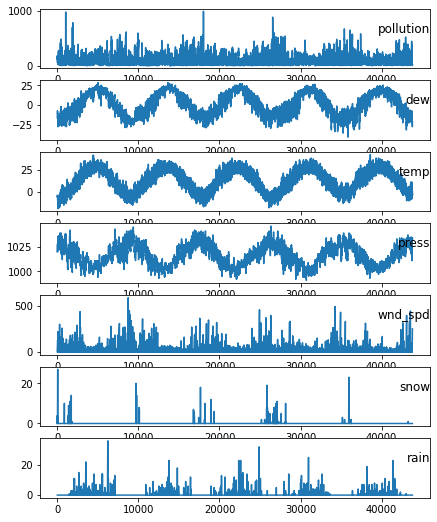

In [17]:
import matplotlib.pyplot as plt
values = data.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(7,9))

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

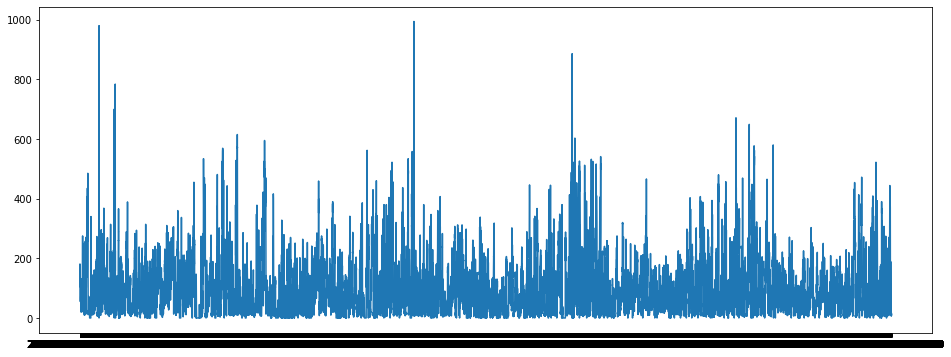

In [9]:
plt.figure(figsize=(16,6))
plt.plot(data.index,data['pollution'].dropna())
plt.show()

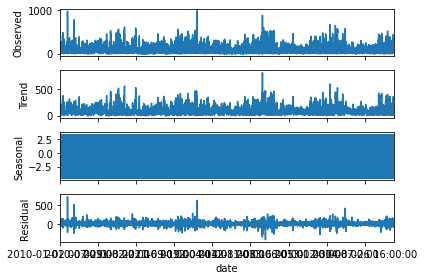

<Figure size 1152x432 with 0 Axes>

In [25]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
#scale change

decomposition = sm.tsa.seasonal_decompose(data['pollution'].dropna(),freq=12, model='additive')
fig = decomposition.plot()
plt.figure(figsize=(16,6))
plt.show()


In [27]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from math import sqrt
from pandas import DataFrame
import pandas as pd
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

Using TensorFlow backend.


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [59]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Train on 8760 samples, validate on 35039 samples
Epoch 1/100
 - 3s - loss: 0.0561 - val_loss: 0.0575
Epoch 2/100
 - 1s - loss: 0.0390 - val_loss: 0.0611
Epoch 3/100
 - 1s - loss: 0.0231 - val_loss: 0.0507
Epoch 4/100
 - 1s - loss: 0.0176 - val_loss: 0.0424
Epoch 5/100
 - 1s - loss: 0.0159 - val_loss: 0.0276
Epoch 6/100
 - 1s - loss: 0.0152 - val_loss: 0.0196
Epoch 7/100
 - 1s - loss: 0.0150 - val_loss: 0.0182
Epoch 8/100
 - 2s - loss: 0.0149 - val_loss: 0.0168
Epoch 9/100
 - 1s - loss: 0.0147 - val_loss: 0.0162
Epoch 10/100
 - 1s - loss: 0.0148 - val_loss: 0.0159
Epoch 11/100
 - 1s - loss: 0.0149 - val_loss: 0.0153
Epoch 12/100
 - 1s - loss: 0.0147 - val_loss: 0.0150
Epoch 13/100
 - 1s - loss: 0.0147 - val_loss: 0.0152
Epoch 14/100
 - 1s - loss: 0.0147 - val_loss: 0.0145
Epoch 15/100
 - 1s - loss: 0.0145 - val_loss: 0.0146
Epoch 16/100
 - 1s - loss: 0.0145 - val_loss: 0.0143
Epoch 17/100
 - 1s - loss: 0.0145 - val_loss: 0.0143
Epoch 18/100
 - 1s - loss: 0.0146 - val_loss: 0.0139
Epoch 

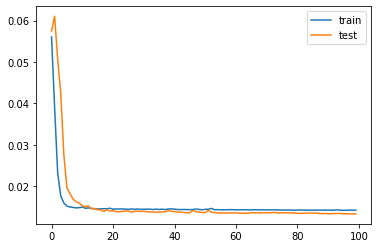

In [30]:
from matplotlib import pyplot
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 3s - loss: 0.0630 - val_loss: 0.0549
Epoch 2/50
 - 1s - loss: 0.0468 - val_loss: 0.0610
Epoch 3/50
 - 1s - loss: 0.0300 - val_loss: 0.0530
Epoch 4/50
 - 1s - loss: 0.0184 - val_loss: 0.0379
Epoch 5/50
 - 1s - loss: 0.0154 - val_loss: 0.0210
Epoch 6/50
 - 1s - loss: 0.0150 - val_loss: 0.0173
Epoch 7/50
 - 1s - loss: 0.0151 - val_loss: 0.0166
Epoch 8/50
 - 1s - loss: 0.0150 - val_loss: 0.0157
Epoch 9/50
 - 1s - loss: 0.0149 - val_loss: 0.0147
Epoch 10/50
 - 1s - loss: 0.0147 - val_loss: 0.0147
Epoch 11/50
 - 1s - loss: 0.0148 - val_loss: 0.0144
Epoch 12/50
 - 1s - loss: 0.0147 - val_loss: 0.0139
Epoch 13/50
 - 1s - loss: 0.0146 - val_loss: 0.0141
Epoch 14/50
 - 1s - loss: 0.0148 - val_loss: 0.0137
Epoch 15/50
 - 1s - loss: 0.0146 - val_loss: 0.0140
Epoch 16/50
 - 1s - loss: 0.0147 - val_loss: 0.0139
Epoch 17/50
 - 1s - loss: 0.0147 - val_loss: 0.0136
Epoch 18/50
 - 1s - loss: 0.0145 - val_loss: 0.0136
Epoch 19/50
 - 1s - loss

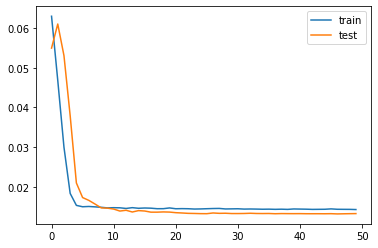

In [60]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [57]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


ValueError: Error when checking input: expected lstm_6_input to have 3 dimensions, but got array with shape (35039, 8)